In [1]:
import numpy as np
import pandas as pd

import re #regex
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout,  LSTM, Dense, Embedding, Bidirectional,BatchNormalization
from tensorflow.keras.optimizers import Adam
import io
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences 

import pickle

from tensorflow.keras import backend as K
import random

from rouge import Rouge #https://towardsdatascience.com/introduction-to-text-summarization-with-rouge-scores-84140c64b471

import copy
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt


print("Num GPUs Available: ", (tf.config.experimental.list_physical_devices()))

ROUGE = Rouge()

2024-07-30 12:16:17.361400: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 12:16:17.391459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 12:16:17.867773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-07-30 12:16:18.512107: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 12:16:18.541466: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 12:16:18.544244: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
#!pip install keras-nlp
import keras_nlp


/home/n/anaconda3/envs/AI_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
buffer_size = 10000
batch_size= 16
window_size= 40 
epochs= 150
embedding_dim = 200

TRAIN_AND_SAVE = True
TRAIN_AND_SAVE_TRANFORMER = True

TRAIN_TEXT= True
SEED=42
TRAIN_TOKEN = True
TUNNING = True
GENERATE_TEXT= True


translationTable = str.maketrans("áéíóúàèìòùâêîôûãõç", "aeiouaeiouaeiouaoc")

In [4]:
# import tensorflow.data as tf_data
# import tensorflow.strings as tf_strings

# keras.utils.get_file(
#     origin="https://dldata-public.s3.us-east-2.amazonaws.com/simplebooks.zip",
#     extract=True,
# )
# dir = os.path.expanduser("~/.keras/datasets/simplebooks/")

# # Load simplebooks-92 train set and filter out short lines.
# raw_train_ds = (
#     tf_data.TextLineDataset(dir + "simplebooks-92-raw/train.txt")
#     .filter(lambda x: tf_strings.length(x) > 512)
#     .batch(batch_size)
#     .shuffle(buffer_size=256)
# )
# for x in raw_train_ds.take(1):
#     print(x)

In [5]:

DATA_CHECKPOINTS_DIR = './checkpoints'
tfrecord_filename = "train_tmp.tfrecord"
train_tmp_record_path = f'{DATA_CHECKPOINTS_DIR}/{tfrecord_filename}'

!mkdir -p {DATA_CHECKPOINTS_DIR}

In [6]:
def prepare_data(path_to_file ='./nietzsche.txt'):
    path_to_file = "./eca_de_queiros_os_maias.txt"
    
    with io.open(path_to_file, encoding='utf-8') as f:
        text = f.read().lower()

    print('corpus length:', len(text))
    text = text.translate(translationTable)

    string_check= re.compile('[^a-zA-Z.?!,:\'<>]')

    text = re.sub(string_check, ' ', (text)
                        .replace("-"," ")
                        .replace("´","'")
                        .replace("`","'")
                        .replace(","," , ")
                        .replace("s."," sao ")
                        .replace("d.","don")
                        .replace("v.","v")
                        .replace("sr.", "senhor")
                        .replace("sra.", "senhora")
                        .replace("exmo.", "exmo")
                        .replace("exma.", "exma")
                        .replace("x.", "x")
    )

    text = re.sub(' +', ' ',text)
    text = (re.sub('\.+', " . \n", text).replace("<br />"," "))

    lines_list = list()
    lines_list = text.split("\n")

    cols = ['sentences']
    df_tmp= pd.DataFrame(columns=cols)
    df_tmp["sentences"] = lines_list

    return df_tmp
complete_text= prepare_data()
complete_text

corpus length: 1266856


sentences
0      a casa que vieram habitar em lisboa , no outon...
1       apesar deste fresco nome de vivenda campestre...
2       longos anos o ramalhete permanecera desabitad...
3       em monsenhor bucarini , nuncio de sao santida...
4       este inutil pardieiro como lhe chamava vilaca...
...                                                  ...
10205   ega , ao lado , ajuntava , ofegante , atirand...
10206   a lanterna vermelha do americano , ao longe ,...
10207   e foi em carlos e em joao da ega uma esperanc...
10208   entao , para apanhar o americano , os dois am...
10209                                                   

[10210 rows x 1 columns]

In [7]:
df= prepare_data()

complete_text = ' '.join(df.sentences.values.tolist())
complete_unique_words_list = list(set(complete_text.split(' ')))
vocab_len = len(complete_unique_words_list)
display(df)
display(vocab_len)
display(complete_unique_words_list)

corpus length: 1266856


sentences
0      a casa que vieram habitar em lisboa , no outon...
1       apesar deste fresco nome de vivenda campestre...
2       longos anos o ramalhete permanecera desabitad...
3       em monsenhor bucarini , nuncio de sao santida...
4       este inutil pardieiro como lhe chamava vilaca...
...                                                  ...
10205   ega , ao lado , ajuntava , ofegante , atirand...
10206   a lanterna vermelha do americano , ao longe ,...
10207   e foi em carlos e em joao da ega uma esperanc...
10208   entao , para apanhar o americano , os dois am...
10209                                                   

[10210 rows x 1 columns]

22255

['',
 'serra',
 'regeladas',
 'tocar',
 'faces',
 'frementes',
 'bilis',
 'capela',
 'monforte!',
 'caricia:',
 'desordem!',
 'arruinados',
 'hotel',
 'transluziam',
 'calva!',
 'indulgencia',
 'romantica!',
 'voluptuosamente',
 'queen',
 'chaile',
 'voltou',
 'tarimbeiro',
 'boulogne',
 'subida',
 'realizava',
 'sofrendo',
 'piaram',
 'desdiga!',
 'serenata',
 'trespassados',
 'parecer',
 'descrevia',
 'passeios',
 'cavalgadura',
 'praguejava',
 'meticulosa',
 'velho!',
 'terraco',
 'seguida',
 'permanecia',
 'divino',
 'prazeres',
 'caldo',
 'facto',
 'traste!',
 'mediocridade',
 'decrepito',
 'viajara',
 'alfandega:',
 'remar!',
 'sossego!',
 'impura',
 'ensopava',
 'extravagancias',
 'absorvido',
 'recusara',
 'entristecia',
 'consulta!',
 'israel',
 'limite',
 'cobrindo',
 'incrivel!',
 'desaparelhar',
 'assistiu',
 'obrigava',
 'aflicao',
 'negar:',
 'cerimonia?',
 'engolidos',
 'mimosa',
 'respeito',
 'coletes',
 'pago',
 'bem:',
 'aterrador',
 'camaradagem',
 'torneada',
 'gros

sentences  sent_length
0      a casa que vieram habitar em lisboa , no outon...           42
1       apesar deste fresco nome de vivenda campestre...          129
3       em monsenhor bucarini , nuncio de sao santida...          210
4       este inutil pardieiro como lhe chamava vilaca...           64
5       nessa ocasiao vendera se outra propriedade d ...           53
...                                                  ...          ...
10178   mas carlos queria realmente saber se , no fun...           49
10188   tudo aceitar , o que vem e o que foge , com a...           61
10192   se me dissessem que ali em baixo estava uma f...           41
10195   e ambos retardaram o passo , descendo para a ...           47
10196   ja avistavam o aterro , a sua longa fila de l...           58

[1781 rows x 2 columns]

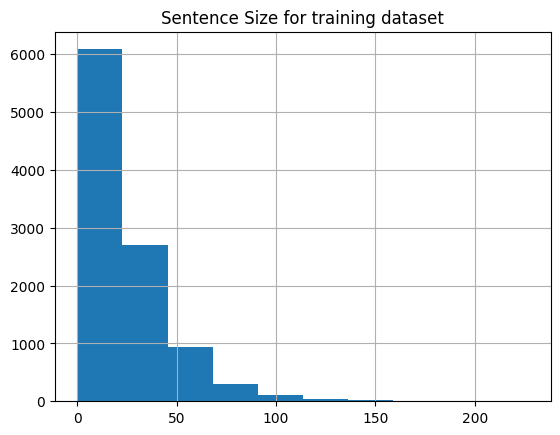

In [8]:
df["sent_length"] = df.sentences.apply(lambda x: len(x.split()))

plt.figure()
pd.Series(df.sent_length).hist()
plt.title("Sentence Size for training dataset")
df[df.sent_length>window_size]

In [9]:
df = df[df.sent_length>=5]
df

sentences  sent_length
0      a casa que vieram habitar em lisboa , no outon...           42
1       apesar deste fresco nome de vivenda campestre...          129
2       longos anos o ramalhete permanecera desabitad...           25
3       em monsenhor bucarini , nuncio de sao santida...          210
4       este inutil pardieiro como lhe chamava vilaca...           64
...                                                  ...          ...
10204   com efeito , nao vale a pena fazer um esforco...           18
10205   ega , ao lado , ajuntava , ofegante , atirand...           33
10206   a lanterna vermelha do americano , ao longe ,...           14
10207   e foi em carlos e em joao da ega uma esperanc...           29
10208   entao , para apanhar o americano , os dois am...           31

[9687 rows x 2 columns]

In [10]:
candidate_list=['data scientist tasks', 'data scientist jobs','data scientist job','data scientist, and','data engineer tasks','data engineer jobs']

def Minimum_Bayes_Risk(list_of_candidates, field = "rouge-l", candidate_reference = None):
    candidate_score = {}
    max_score = 0
    best_score_candidate= ''
    best_candidate_index = -1
    if candidate_reference == None :
        for candidate_ref in list_of_candidates:
            
            rest_of_candidates = copy.deepcopy(list_of_candidates)
            if candidate_ref in rest_of_candidates : rest_of_candidates.remove(candidate_ref)
            score = 0

            for candidate in rest_of_candidates:
                score += ROUGE.get_scores(candidate, candidate_ref)[0][field]["f"]
            
            score = score/len(rest_of_candidates)

            candidate_score[candidate_ref] = score

            if score >= max_score:
                best_score_candidate =candidate_ref
                best_candidate_index = list_of_candidates.index(candidate_ref)
                max_score = score

    else:
            
            for candidate in list_of_candidates:
                score = 0
                score = ROUGE.get_scores(candidate, candidate_reference)[0][field]["f"]
                if score >= max_score:
                    best_score_candidate =candidate_ref


    return candidate_score, best_score_candidate, best_candidate_index

candidate_score, best_score_candidate, best_candidate_index = Minimum_Bayes_Risk(candidate_list)
candidate_score, best_score_candidate , best_candidate_index

({'data scientist tasks': 0.5333333283333335,
  'data scientist jobs': 0.5333333283333335,
  'data scientist job': 0.4666666616666668,
  'data scientist, and': 0.3333333283333334,
  'data engineer tasks': 0.4666666616666667,
  'data engineer jobs': 0.4666666616666667},
 'data scientist jobs',
 1)

# Getting vocabs and tokenizing the text

In [11]:
from sklearn.model_selection import train_test_split
df_train, df_val_test = train_test_split(df,test_size=0.2,train_size=0.8)

display(df_train)
display(df_val_test)

sentences  sent_length
5113   para que servia entao o grande movimento natu...           36
7606   o ministro da finlandia abriu os bracos para ...           25
9375   e se nao partes para santa olavia , eu vou pa...           13
1332   que perguntavas tu , filho? disse enfim afons...           47
9956                      o que , o damaso , coitado .             8
...                                                 ...          ...
9027   o avo deve saber! afonso da maia , que um tre...           33
2585                           tudo isto o assustava .             5
5314      comecava eu entao a minha carreira publica .             8
9374                   recebi uma carta de minha mae .             7
5287   carlos encolheu os ombro sao como podia ela a...           21

[7749 rows x 2 columns]

sentences  sent_length
4919    tinha diante de si os tres meses em que ela e...           31
5034    pareceu lhe que trazia o ar escorracado , e s...           15
1612                                isto so a pontape .             5
9806    olha este horror! a ciencia para tudo acha um...           24
1262    foi um tio , um negociante de calcuta ou de a...           21
...                                                  ...          ...
9561    e , sobre a rua deserta , cerrou se finalment...           19
10192   se me dissessem que ali em baixo estava uma f...           41
2978                   vamos indo primeiro a lawrence .             6
7245    mas o domingos servia o anana sao e o ega pro...           18
6792                         carlos parara , comovido .             5

[1938 rows x 2 columns]

In [12]:

df_test, df_val = train_test_split(df_val_test, test_size = 0.25,train_size =0.75)
display(df_test)
display(df_val)

sentences  sent_length
9453             carlos beijou a mao fria que pendia .             8
8871   que diabo , senhor , e necessario ter topete!...           30
8476   por fim carlos atirou o contra a porta duma c...           11
8711   acendeu a sua palmatoria entreabriu o reposte...           24
1673                         ouco por ali lamenta la .             6
...                                                 ...          ...
3496                          carlos entao zangou se .             5
3996   nao temos nada capaz de dar a um rapaz um boc...           14
2398                           eu ca vou de selvagem .             6
1890   alencar ja tinha carlos estreitado ao peito ,...           90
1559   ao findar o atomo exclamava , com a vasta sol...           51

[1453 rows x 2 columns]

sentences  sent_length
1032           matriculou se realmente com entusiasmo .             6
10009   isto e fantastico , ega! ega esfregava as mao...           26
6745    ia a descer a vidraca que faltava a correia q...           20
335     maria sentia lhes por cima as risada sao as v...           14
2730    dai a pouco cruges , que devorava , exclamou ...           26
...                                                  ...          ...
5237    por isso ninguem agora lograva ter os seus sa...           38
7753    e ele , bondoso como era , prometia , dizia: ...           55
5703    nao se tinham visto desde as corridas , o poe...           25
9439    os criados em redor olharam , aterrado sao e ...           52
2685                       e nao digas nada la dentro .             7

[485 rows x 2 columns]

In [13]:
train_tfds = tf.data.Dataset.from_tensor_slices(
        (
            df_train.sentences.tolist()
        )
    ).batch(batch_size).shuffle(buffer_size=len(df_train)).prefetch(tf.data.AUTOTUNE)
for x in train_tfds.take(1):
    print(x)

tf.Tensor(
[b' aqui e alem esvoacava um lenco branco . '
 b' carlos , entusiasmado com a letra dela , quasi comparavel a lendaria letra do damaso , ocupava a agora incessantemente como copista , sentindo mais amor por um trabalho a que ela se associava . '
 b' quer voce fazer uma partida de bilhar , o marques? va la , homem . '
 b' a mama nao saia do catre , doente , sucumbida , chorando . '
 b' e o ega , o grande ega? . '
 b' e limpando negligentemente o monoculo ao lenco de seda branca: uma judia . '
 b' depois abria se um intermedio panteista: rompiam coros de flores , coros de astros , cantando na linguagem da luz , ou na eloquencia dos perfumes , a beleza , a graca , a pureza , a alma celeste de ester e de rachel . '
 b' nos tons agudos todo ele se ia alcando sobre a ponta dos pes , como levado no compasso vivo despegava entao a mao do peito , alargava um gesto , as belas joias dos seus aneis faiscavam . '
 b' nao ha outro , e unico! o bom deus fe lo num dia de grande verve , e de

2024-07-30 12:16:19.494292: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 12:16:19.498322: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 12:16:19.501298: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [14]:
dev_tfds = tf.data.Dataset.from_tensor_slices(
        (
            df_val.sentences.tolist()
        )
    ).batch(batch_size).shuffle(buffer_size=len(df_val)).prefetch(tf.data.AUTOTUNE)
for x in dev_tfds.take(1):
    print(x)

test_tfds = tf.data.Dataset.from_tensor_slices(
        (
            df_test.sentences.tolist()
        )
    ).batch(batch_size).shuffle(buffer_size=len(df_test)).prefetch(tf.data.AUTOTUNE)
for x in test_tfds.take(1):
    print(x)

tf.Tensor(
[b' matriculou se realmente com entusiasmo . '
 b' isto e fantastico , ega! ega esfregava as mao sao sim , mas precioso! porque essa simples forma de botas explicava todo o portugal contemporaneo . '
 b' ia a descer a vidraca que faltava a correia quando a tipoia parou de repente , na estrada solitaria . '
 b' maria sentia lhes por cima as risada sao as vezes tocava se viola . '
 b' dai a pouco cruges , que devorava , exclamou com a boca cheia: o reno tambem deve ser magnifico! carlos olhou o espantado e rindo . '
 b' alem disso , ega nao saberia tudo , mais tarde ou mais cedo , pela tagarelice alheia? antes lho dissesse ele , fraternalmente . '
 b' olha este horror! a ciencia para tudo acha um remedio , menos para a calva! transformam se as civilizacoes , a calva fica! . '
 b' e ela? oh , ela dormira dum sono so . ' b' ega ja pensara nisso . '
 b' foi um tio , um negociante de calcuta ou de australia , um nababo , que lhe deixou a fortuna . '
 b' mas o pior nao foi isso . '

2024-07-30 12:16:19.877125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-30 12:16:19.887974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
## Train tokenizer vocabulary on training data only. Words that occur only on the test data will be unknown, and this is the expected behaviour when considering real word environment.

vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_tfds,
    vocabulary_size=vocab_len,
    lowercase=True,
    reserved_tokens=["[PAD]", "[UNK]", "[BOS]"]#, "[EOS]"],
)

#WordPieceTokenizer is an efficient implementation of the WordPiece algorithm used by BERT and other models. 
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    sequence_length=window_size,
    lowercase=True,
)

2024-07-30 12:16:20.403609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
# packer adds a start token
start_packer = keras_nlp.layers.StartEndPacker(
    sequence_length=window_size,
    start_value=tokenizer.token_to_id("[BOS]"),
    #end_value = tokenizer.token_to_id("[EOS]"),
)

def preprocess(inputs):
    outputs = tokenizer(inputs)
    features = start_packer(outputs)
    labels = outputs
    return features, labels

train_tfds= train_tfds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

dev_tfds= dev_tfds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)


test_tfds= test_tfds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

print("Training set ...")
for i, o in train_tfds.take(1):
    print("input : ",i[0])
    print("output : ",o[0])
    print("Detokenized input: ",tokenizer.detokenize(i[0]))
    print("Detokenized output: ",tokenizer.detokenize(o[0]))


print("Dev set ...")
for i, o in dev_tfds.take(1):
    print("input : ",i[0])
    print("output : ",o[0])
    print("Detokenized input: ",tokenizer.detokenize(i[0]))
    print("Detokenized output: ",tokenizer.detokenize(o[0]))


print("Testing set ...")
for i, o in test_tfds.take(1):
    print("input : ",i[0])
    print("output : ",o[0])
    print("Detokenized input: ",tokenizer.detokenize(i[0]))
    print("Detokenized output: ",tokenizer.detokenize(o[0]))

Training set ...
input :  tf.Tensor(
[   2   44   38    8  887   81 1295    8   42 1250  140    8   37   34
  222 1298  274  407    5    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32)
output :  tf.Tensor(
[  44   38    8  887   81 1295    8   42 1250  140    8   37   34  222
 1298  274  407    5    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32)
Detokenized input:  tf.Tensor(b'[BOS] nao se abandonar a uma esperanca nem a um desapontamento . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', shape=(), dtype=string)
Detokenized output:  tf.Tensor(b'nao se abandonar a uma esperanca nem a um desapontamento . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', shape

2024-07-30 12:16:33.068844: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2024-07-30 12:16:33.113053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-30 12:16:33.248788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


input :  tf.Tensor(
[   2 2523   38   70  100    4   47  176  642 1789   43    5    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32)
output :  tf.Tensor(
[2523   38   70  100    4   47  176  642 1789   43    5    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32)
Detokenized input:  tf.Tensor(b'[BOS] passa se la bem , as tercas feira sao . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', shape=(), dtype=string)
Detokenized output:  tf.Tensor(b'passa se la bem , as tercas feira sao . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

2024-07-30 12:16:33.383765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Training

In [17]:

class TextGenerator(tf.keras.Model):
    def __init__(
        self, 
        vocab_len = vocab_len, 
        window_size = window_size, 
        embedding_dim = embedding_dim,  
        n_layers = 1, 
        n_attention_head = 2, 
        feed_forward_dim = [128],
        dropout_rate = [0.0]):
        super(TextGenerator, self).__init__()
        
        self.num_layers = n_layers
        self.n_attention_head =n_attention_head
        self.feed_forward_dim = feed_forward_dim
        self.dropout_rate = dropout_rate

        self.embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=vocab_len,
            sequence_length=window_size,
            embedding_dim=embedding_dim,
            mask_zero=True,
        )
        
        self.decoder_layer = [keras_nlp.layers.TransformerDecoder(num_heads=self.n_attention_head, intermediate_dim=self.feed_forward_dim[i],dropout = dropout_rate[i]) for i in range(self.num_layers)]
        self.output_dense = Dense(vocab_len)

    def call(self, inputs):
        x = self.embedding_layer(inputs)
        for i in range(self.num_layers ):
            x = self.decoder_layer[i](x)

        outputs_logits  = self.output_dense(x)

        return outputs_logits


# generate_text_model = TextGenerator(
#     vocab_len = vocab_len,
#     window_size = window_size, 
#     embedding_dim = embedding_dim,  
#     n_layers = 1, 
#     n_attention_head = 2, 
#     feed_forward_dim = [128],
#     dropout_rate = [0.0]
#     )

# loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# perplexity = keras_nlp.metrics.Perplexity(from_logits=True, mask_token_id=0)

# generate_text_model.compile(
#     loss=loss_fn, 
#     optimizer=Adam(learning_rate=0.0005), 
#     metrics=[perplexity])

# for i, o in train_tfds.take(1):
#     print(i.shape, o.shape)
#     print(generate_text_model(i).shape)

# generate_text_model.summary()

In [18]:

# generate_text_model.fit(train_tfds, validation_data= dev_tfds, epochs=epochs, batch_size=32, verbose =1, callbacks=[stop_early, tensorboard_callback, text_generation_callback])


# Inference functions

In [19]:
prompt_tokens = start_packer(tokenizer([""]))
prompt_tokens

<tf.Tensor: shape=(1, 40), dtype=int32, numpy=
array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>

In [20]:
def next(prompt, cache, index):
    logits = generate_text_model(prompt)[:, index - 1, :]
    # Ignore hidden states for now; only needed for contrastive search.
    hidden_states = None
    return logits, hidden_states, cache

# Training and tunning process

In [21]:
class TopKTextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model using top-k."""

    def __init__(self, k):
        self.top_k_sampler = keras_nlp.samplers.TopKSampler(k)
        #self.beam_search_sampler = keras_nlp.samplers.BeamSampler(num_beams=10)

    def on_epoch_end(self, epoch, logs=None):
        output_tokens = self.top_k_sampler(
            next=next,
            prompt=prompt_tokens,
            index=1,
        )
        txt = tokenizer.detokenize(output_tokens)
        print(f"Top-K search generated text: \n{txt}\n")
        
text_generation_callback = TopKTextGenerator(k=10)


In [22]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/training/")

def get_model_tunning(hp):


    n_att_layers = hp.Int('n_att_layers', 1, 3)
    n_attention_head= hp.Int('n_att_layers', 1, 3)
    feed_forward_dim_list = []
    dropout_rate = []
    if n_att_layers > 0:
        feed_forward_dim_list =  [hp.Int('att_units_'+str(i), 32, 128) for i in range(n_att_layers)]
        dropout_rate=  [hp.Float('att_dropout_rate_'+str(i), 0.0, 0.5, step = 0.1) for i in range(n_att_layers)]
    
    hp_learning_rate = hp.Float('learning_rate', 0.000001, 0.001)
    embedding_dim_list = 150#hp.Int('embedding_dim', 100,  200, step = 50)
    
    model = TextGenerator(
        vocab_len = vocab_len,
        window_size = window_size, 
        embedding_dim = embedding_dim_list,  
        n_layers = n_att_layers, 
        n_attention_head = n_attention_head, 
        feed_forward_dim = feed_forward_dim_list,
        dropout_rate = dropout_rate
    )

    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    perplexity = keras_nlp.metrics.Perplexity(from_logits=True, mask_token_id=0)

    model.compile(
        loss=loss_fn, 
        optimizer=Adam(learning_rate=hp_learning_rate), 
        metrics=[perplexity],
        )

    for i, o in train_tfds.take(1):
        print(i.shape, o.shape)
        print(model(i).shape)

    return model


tuner = kt.BayesianOptimization(
        get_model_tunning,
        objective= kt.Objective('val_perplexity', direction="min"), #kt.Objective('val_auc', direction="max"),# #val_binary_accuracy
        max_trials = 30,
        directory=r"Hyperparam_tunning",
        project_name='keras_att_tunning',
    )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)#val_auc
if TUNNING:
    tuner.search(train_tfds,  epochs=100, batch_size=batch_size, validation_data = test_tfds, verbose =1, callbacks=[stop_early, tensorboard_callback]) 

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps


Reloading Tuner from Hyperparam_tunning/keras_att_tunning/tuner0.json


In [27]:
for i, best_hps in enumerate(tuner.get_best_hyperparameters(num_trials=3)):
    print(f"Best Hyperparameters: {best_hps.__dict__}")
    text_generator_model = tuner.hypermodel.build(best_hps)  # Build the model with best hyperparameters
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/attention_training/model{i}")
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)#val_auc
    text_generator_model.fit(train_tfds,  epochs=300, batch_size=batch_size, validation_data = test_tfds, verbose =1, callbacks=[stop_early, tensorboard_callback]) 

Best Hyperparameters: {'_name_scopes': [], '_conditions': [], '_hps': defaultdict(<class 'list'>, {'n_att_layers': [Int(name: 'n_att_layers', min_value: 1, max_value: 3, step: 1, sampling: linear, default: 1)], 'att_units_0': [Int(name: 'att_units_0', min_value: 32, max_value: 128, step: 1, sampling: linear, default: 32)], 'att_dropout_rate_0': [Float(name: 'att_dropout_rate_0', min_value: '0.0', max_value: '0.5', step: '0.1', sampling: 'linear', default: '0.0')], 'learning_rate': [Float(name: 'learning_rate', min_value: '1e-06', max_value: '0.001', step: 'None', sampling: 'linear', default: '1e-06')], 'att_units_1': [Int(name: 'att_units_1', min_value: 32, max_value: 128, step: 1, sampling: linear, default: 32)], 'att_dropout_rate_1': [Float(name: 'att_dropout_rate_1', min_value: '0.0', max_value: '0.5', step: '0.1', sampling: 'linear', default: '0.0')], 'att_units_2': [Int(name: 'att_units_2', min_value: 32, max_value: 128, step: 1, sampling: linear, default: 32)], 'att_dropout_rate_

2024-07-30 14:24:37.096057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


485/485 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 6.5315 - perplexity: 1394.6074 - val_loss: 4.9800 - val_perplexity: 165.5515
Epoch 2/300
485/485 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.8202 - perplexity: 140.9274 - val_loss: 4.6483 - val_perplexity: 117.8062
Epoch 3/300
485/485 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.3936 - perplexity: 90.9605 - val_loss: 4.5105 - val_perplexity: 102.2704
Epoch 4/300
485/485 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.1371 - perplexity: 69.6579 - val_loss: 4.4512 - val_perplexity: 96.2299
Epoch 5/300
485/485 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.9007 - perplexity: 54.7768 - val_loss: 4.4449 - val_perplexity: 95.6116
Epoch 6/300
485/485 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.6659 - perplexity: 43.1885 - val_loss: 4.4811 - val_perplexity: 99.2324
Epoch 7/300
485/485 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.4613 - perplexity: 34.9248 - val_loss: 4.5564 - val_perplexity: 107.2001
Epoch 8/300
485/485 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - los

In [24]:
aaaaaaaaaaaaaaaaaaaaa

NameError: name 'aaaaaaaaaaaaaaaaaaaaa' is not defined

# Inference using different techniques

## Greedy sampling approach

In [ ]:
sampler = keras_nlp.samplers.GreedySampler()
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,  # Start sampling immediately after the [BOS] token.
)
txt = tokenizer.detokenize(output_tokens)
print(f"Greedy search generated text: \n{txt}\n")

## Beam Search approach

In [ ]:
sampler = keras_nlp.samplers.BeamSampler(num_beams=10)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Beam search generated text: \n{txt}\n")

## Random Search approach

In [ ]:
sampler = keras_nlp.samplers.RandomSampler()
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Random search generated text: \n{txt}\n")

## Top-K search approach

In [ ]:
sampler = keras_nlp.samplers.TopKSampler(k=10)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-K search generated text: \n{txt}\n")

## Top-P search approach
 

In [ ]:
sampler = keras_nlp.samplers.TopPSampler(p=0.5)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-P search generated text: \n{txt}\n")

# Attention Analysis

In [ ]:
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [ ]:
for i, o in dataset.take(1):aaaaaaaaaaaaaaaaaa
    print(i)
    
emb_layer = Embedding(input_dim=vocab_len, input_length = window_size, output_dim=emb_dim, weights=[embeddings_matrix] ,name ="emb_layer", trainable=False, mask_zero = True)

attention_layer = SelfMaskedDotProductAttention()
attention_layer_causal1 = SelfMaskedDotProductAttention()
#attention_layer_causal2 = SelfMaskedDotProductAttention(causal_mask_enabled=2)

emb_layer = Embedding(input_dim=vocab_len, input_length = window_size, output_dim=emb_dim, weights=[embeddings_matrix] ,name ="emb_layer", trainable=False, mask_zero = True)
query = emb_layer(i)
values = emb_layer(i)

context_vector, attention_weights = attention_layer(query,values,values, (i != 0))
context_vector1, attention_weights1 = attention_layer_causal1(query,values,values, (i != 0))
context_vector1, attention_weights_causal = attention_layer_causal1(query,values,values, (i != 0), (1 - tf.linalg.band_part(tf.ones((i.shape[1], i.shape[1])), -1, 0)))



plt.figure(figsize=(14,7))
plt.subplot(3, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights - Not causal')

plt.subplot(3, 2, 2)
plt.pcolormesh(i != 0)
plt.title('Mask')

plt.subplot(3, 2, 3)
plt.pcolormesh(attention_weights1[:, 0, :])
plt.title('Attention weights 1')

plt.subplot(3, 2, 4)
plt.pcolormesh(attention_weights[0])
plt.title('Attention weights')

plt.subplot(3, 2, 5)
plt.pcolormesh(attention_weights1[0])
plt.title('Attention weights 1')

plt.subplot(3, 2, 5)
plt.pcolormesh(attention_weights_causal[0])
plt.title('Attention weights causal')

In [ ]:
blstm_enable = False

if TRAIN_AND_SAVE:
    model = ModelClass(vocab_len, model_type=1, causal_mask_enabled= 0, blstm_enable=blstm_enable, use_attention=False)
    model.compile(loss=MaskedLossCustom(), optimizer=Adam(learning_rate=0.0005), metrics=[tf.metrics.SparseCategoricalAccuracy()])

    model_causal1 = ModelClass(vocab_len, model_type=1, causal_mask_enabled= 1, blstm_enable=blstm_enable, loop= False)
    model_causal1.compile(loss=MaskedLossCustom(), optimizer=Adam(learning_rate=0.0005), metrics=[tf.metrics.SparseCategoricalAccuracy()])


In [ ]:
vocab_size = vocab_len
token_mask_ids = np.array([tokenizer.word_index[x] for x in  [ '<oov>', '[EOS]' ]])[:, None]#
token_mask = np.zeros([vocab_size], dtype=np.bool)
token_mask[np.array(token_mask_ids)] = True

print("token_mask", token_mask)


def generate_sentence(model_inst, input_text, max_length=10, temperature=0.5, number_of_candidates = 20, ):
    
    
    attention_per_candidate = []
    result_text_per_candidate = []
    input_text_per_candidate = []
    output_text_per_candidate = []

    for c in range(number_of_candidates):

        last_state= None
        last_activation = None
        input_mask = None
        last_attention = None

        result_tokens = []
    
        attention = []

        x = input_tokens
        input_text= []
        output_text = []
        result_tokens = [w.numpy() for w in  x[0] if w != 0 ]
        for k in range(max_length):

            input_text.append(' '.join([tokenizer.index_word[w.numpy()] for w in  x[0] if w != 0 ]))
            x = pad_sequences(x, padding = "post", maxlen = window_size)#

            input_mask = x!= 0
            t = np.count_nonzero(input_mask)

            if no_state: last_state= None

            predictions, last_state , attention_weights, last_activation, last_attention  =model_inst(x, last_attention, last_state,  last_activation)

            if k > 0 and attention_weights is not None:
                attention.append(attention_weights[0])

            predicted_logits  = predictions[:,t-1,:]/temperature
            predicted_logits = tf.where(token_mask, -np.inf, predicted_logits)
            predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
            new_tokens = tf.squeeze(predicted_ids, axis=-1)

            if loop:
            
                x = new_tokens.numpy()
            else : 

                x = list(x[0])
                x = [i for i in x if i != 0]
                x.append(new_tokens.numpy()[0])
                

            output_text.append(' '.join([tokenizer.index_word[w] for w in  x if w != 0 ][1:]))
            x = tf.reshape(tf.convert_to_tensor(x), (len(input_tokens),len(x)))
            result_tokens.append(new_tokens.numpy()[0])
                
            if tokenizer.word_index['[EOS]'] == new_tokens.numpy()[0]:
                break


        result_text =   ' '.join([tokenizer.index_word[w] for w in  result_tokens if w != 0 ])
        
        attention_per_candidate.append(attention)
        result_text_per_candidate.append(result_text)
        input_text_per_candidate.append(input_text)
        output_text_per_candidate.append(output_text)

    candidate_score, best_score_candidate, best_candidate_index = Minimum_Bayes_Risk(result_text_per_candidate)

    attention_stack = attention_per_candidate[best_candidate_index]
    result_text = result_text_per_candidate[best_candidate_index]
    input_text = input_text_per_candidate[best_candidate_index]
    output_text = output_text_per_candidate[best_candidate_index]
    
    return {'generated_text': result_text, 'attention': attention_stack, "input_text" : input_text, "output_text" : output_text, "candidates": result_text_per_candidate}



In [ ]:
if TRAIN_AND_SAVE:
    input_sent = "[BOS] eu quero "
    inp_seq = np.array([tokenizer.word_index[x] for x in input_sent.split()])
    print("inp_seq -->",inp_seq)

    result = generate_sentence(model_causal1, input_tokens = tf.expand_dims(inp_seq,0),max_length= 5)
    print("RESULT : ",result["generated_text"])
    plot_weights(result, stop_time = 3, loop=True)

    result = generate_sentence(model_causal1, input_tokens = tf.expand_dims(inp_seq,0),max_length= 5, loop=True)


In [ ]:
if TRAIN_AND_SAVE:
    model.use_tf_function = False
    for i, o in dataset.take(2):
        print(model.train_step([i, o]))
        print(model.test_step([i, o]))
    print()

    model_causal1.use_tf_function = False
    for i, o in dataset.take(2):
        print(model_causal1.train_step([i, o]))
        print(model_causal1.test_step([i, o]))
    print()

    print("\n---------------------\n")

    model.use_tf_function = True
    for i, o in dataset.take(2):
        print(model.train_step([i, o]))
        print(model.test_step([i, o]))
    print()

    model_causal1.use_tf_function = True
    for i, o in dataset.take(2):
        print(model_causal1.train_step([i, o]))
        print(model_causal1.test_step([i, o]))

    print()
    

In [ ]:
if TRAIN_AND_SAVE:
    
    history = model.fit(dataset, epochs=epochs, shuffle= True,#6000
                        steps_per_epoch = train_size, callbacks=[PlotLossesCallback()], validation_data=val_dataset, validation_steps=10)
    model.save_weights("./checkpoints/model_ckpt")

    with open('./checkpoints/history.pickle', 'wb') as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else :
    print("Loading saved data ...")
    model = ModelClass(vocab_len, model_type=1, causal_mask_enabled= 0, blstm_enable=blstm_enable, use_attention=False)
    model.load_weights("./checkpoints/model_ckpt")

    with open('./checkpoints/history.pickle', 'rb') as handle:
        history = pickle.load(handle)
        plt.figure()
        plt.plot(history['sparse_categorical_accuracy'])
        plt.plot(history['val_sparse_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history['perplexity'])
        plt.plot(history['val_perplexity'])
        plt.title('Model perplexity ')
        plt.ylabel('Perplexity')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.show()
 

In [ ]:
if TRAIN_AND_SAVE:
    
    history_causal1 = model_causal1.fit(dataset, epochs=epochs+100, shuffle= True, #6000
                        steps_per_epoch = train_size, callbacks=[PlotLossesCallback()], validation_data=val_dataset, validation_steps=10)
    model_causal1.save_weights("./checkpoints/model_causal1_ckpt")

    with open('./checkpoints/history_causal1.pickle', 'wb') as handle:
        pickle.dump(history_causal1.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else :
    print("Loading saved data ...")
    model_causal1 = ModelClass(vocab_len, model_type=1, causal_mask_enabled= 1, blstm_enable=blstm_enable, loop= False)

    model_causal1.load_weights("./checkpoints/model_causal1_ckpt")

    with open('./checkpoints/history_causal1.pickle', 'rb') as handle:
        history_causal1 = pickle.load(handle)
        plt.figure()
        plt.plot(history_causal1['sparse_categorical_accuracy'])
        plt.plot(history_causal1['val_sparse_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_causal1['loss'])
        plt.plot(history_causal1['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_causal1['perplexity'])
        plt.plot(history_causal1['val_perplexity'])
        plt.title('Model perplexity ')
        plt.ylabel('Perplexity')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.show()

# Transformer Decoder


In [ ]:
def scaled_dot_product_attention(q, k, v, padding_mask= None, look_ahead_mask= None):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)


  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if padding_mask is not None:
    scaled_attention_logits += (padding_mask * -1e9)

  if look_ahead_mask is not None:
    scaled_attention_logits += (look_ahead_mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = Dense(d_model)
    self.wk = Dense(d_model)
    self.wv = Dense(d_model)

    self.dense = Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, padding_mask, look_ahead_mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention( q, k, v, padding_mask, look_ahead_mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
batch_size = 10
n_vectors = 150
d_model = 256

query = tf.random.uniform((batch_size, n_vectors, d_model), dtype=tf.float32)
key = tf.random.uniform((batch_size, n_vectors, d_model), dtype=tf.float32)
value = tf.random.uniform((batch_size, n_vectors, d_model), dtype=tf.float32)
query.shape, key.shape

In [ ]:
# Test dot product attention
x,_ = scaled_dot_product_attention(query, key, key, None)
print(f"Output from dot product attention: {x.shape}")

att = SelfMaskedDotProductAttention()
x1, _ = att(query, key,key)
#x = tf.concat(x, -1)
print(f"Output from dot product attention: {x1.shape}")
np.where((x-x1) > 0.1)

In [ ]:
# Test multi-head attention
mh_layer = MultiHeadAttention(d_model=512, num_heads=8)
x, _ = mh_layer(query, key, value, None, None)
print(f"Output from multi-head attention: {x.shape}")

In [ ]:
def point_wise_feed_forward_network(d_model, dff): #Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.
  return tf.keras.Sequential([
      Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)

    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)

  def call(self, x, training, padding_mask= None, look_ahead_mask = None):
    attn_output, attn_weights_block1  = self.mha(x, x, x, padding_mask, look_ahead_mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2, attn_weights_block1


sample_encoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=batch_size)
sample_encoder_layer_output,attn_weights_block1 = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)
sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

n, d = 2048, vocab_len
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, embeddings_matrix, window_size, num_heads, dff, vocab_len,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.emb_layer = Embedding(input_dim=vocab_len, input_length = window_size, output_dim=d_model, weights=[embeddings_matrix] ,name ="emb_layer2", trainable=False)#, mask_zero = True
    self.pos_encoding = positional_encoding(window_size, self.d_model)

    self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, padding_mask =None, look_ahead_mask= None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.emb_layer(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1 = self.dec_layers[i](x, training, padding_mask, look_ahead_mask)
      attention_weights[f'decoder_layer{i+1}_block1'] = block1


    return x ,attention_weights # (batch_size, input_seq_len, d_model)

sample_decoder = Decoder(num_layers=2, d_model=emb_dim, embeddings_matrix = embeddings_matrix, window_size= window_size, num_heads=10,
                         dff=2048, vocab_len=vocab_len)

for i, o in dataset.take(1):
  print(i.shape, o.shape)
  output, attn = sample_decoder(i, training=True, padding_mask =None, look_ahead_mask= None)
  
output.shape, attn['decoder_layer2_block1'].shape

In [ ]:
class CustomLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss_transformer_custom'
    self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

  def __call__(self, real, pred):
      
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = self.loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  real = tf.cast(real, dtype=tf.int32)
  accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=2), dtype=tf.int32))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
  

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)



In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,*, num_layers, d_model,embeddings_matrix,window_size, num_heads, dff,  vocab_len,rate=0.1, use_tf_function= False):
        super().__init__()

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model, embeddings_matrix = embeddings_matrix,
                            window_size= window_size, num_heads=num_heads, dff=dff, vocab_len=vocab_len, rate=rate)

        self.final_layer = Dense(vocab_len)
        self.use_tf_function = use_tf_function

    def call(self, inputs, training):
        # Keras models prefer if you pass all your inputs in the first argument
        inp = inputs

        padding_mask, look_ahead_mask = self.create_masks(inp)
        
        # dec_output.shape == (batch_size, inp_seq_len, d_model)
        dec_output, attention_weights = self.decoder(inp, training, padding_mask, look_ahead_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, vocab_len)

        return final_output, attention_weights

    def create_masks(self, inp):
        # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
        
        padding_mask = self.create_padding_mask(inp)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = self.create_look_ahead_mask(tf.shape(inp)[1])

        return padding_mask, look_ahead_mask

    def create_padding_mask(self,seq):
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

        # add extra dimensions to add the padding
        # to the attention logits.
        return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

    def create_look_ahead_mask(self, size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  # (seq_len, seq_len)

    def train_step(self, inputs):
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.int32, shape=[None, window_size]),
                                tf.TensorSpec(dtype=tf.int32, shape=[None, window_size])]])
                                
    def _tf_train_step(self, inputs):
        return self._train_step(inputs)



    def test_step(self, inputs):
        if self.use_tf_function:
            return self._tf_test_step(inputs)
        else:
            return self._test_step(inputs)


    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.int32, shape=[None, window_size]),
                                tf.TensorSpec(dtype=tf.int32, shape=[None, window_size])]])
    def _tf_test_step(self, inputs):
        return self._test_step(inputs)


    def _train_step(self, inputs):
        inp, tar = inputs
        target_mask = tar != 0     
        
        with tf.GradientTape() as tape:
            acc = []
            loss = tf.constant(0.0)

            predictions, _ = self.call(inp,training = True)
            loss += self.loss(tar, predictions)
            self.compiled_metrics.update_state(tar, predictions)

            acc.append(self.metrics[0].result())

            average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))  
            average_acc  = tf.reduce_mean(tf.convert_to_tensor(acc) )
            average_perplexity  = tf.reduce_mean(tf.convert_to_tensor(perplexity(tar, predictions) ))
            average_cc  = tf.reduce_mean(tf.convert_to_tensor(accuracy_function(tf.cast(tar, tf.int32), predictions) ))

        variables = self.trainable_variables 
        gradients = tape.gradient(average_loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))

        m = {m.name: average_acc  for m in self.metrics} #.update({'loss': batch_loss})m.result() 
        m["loss"] = average_loss
        m["perplexity"] = average_perplexity
        m["custom_acc"] = average_cc

        return m

    def _test_step(self, inputs):
        inp, tar = inputs
        target_mask = tar != 0     

        acc = []
        loss = tf.constant(0.0)

        predictions, _ = self.call(inp,training = True)
        loss += self.loss(tar, predictions)
        self.compiled_metrics.update_state(tar, predictions)

        acc.append(self.metrics[0].result())

        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))  
        average_acc  = tf.reduce_mean(tf.convert_to_tensor(acc) )
        average_perplexity  = tf.reduce_mean(tf.convert_to_tensor(perplexity(tar, predictions) ))
        average_cc  = tf.reduce_mean(tf.convert_to_tensor(accuracy_function(tf.cast(tar, tf.int32), predictions) ))

        m = {m.name: average_acc  for m in self.metrics} #.update({'loss': batch_loss})m.result() 
        m["loss"] = average_loss
        m["perplexity"] = average_perplexity
        m["custom_acc"] = average_cc

        return m


transformer = Transformer(
    num_layers=4,
    d_model=emb_dim,
    embeddings_matrix = embeddings_matrix,
    window_size = window_size,
    num_heads=10,
    dff=256,
    vocab_len=vocab_len,
    rate=0.1)

for i, o in dataset.take(1):
    print(i.shape, o.shape)
    fn_out, _ = transformer(i, training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

transformer.compile(loss=CustomLoss(), optimizer=optimizer, metrics=[tf.metrics.SparseCategoricalAccuracy()])


In [ ]:

def generate_sentence_for_transformer(transformer_inst, input_tokens, max_length=10, temperature=1, number_of_candidates = 20, loop= False):
    
    attention_per_candidate = []
    result_text_per_candidate = []
    input_text_per_candidate = []
    output_text_per_candidate = []

    for c in range(number_of_candidates):

        input_mask = None
        result_tokens = []
        attention = []

        x = input_tokens
        input_text= []
        output_text = []
        result_tokens = [w.numpy() for w in  x[0] if w != 0 ]
        for k in range(max_length):

            input_text.append(' '.join([tokenizer.index_word[w.numpy()] for w in  x[0] if w != 0 ]))
            x = pad_sequences(x, padding = "post", maxlen = window_size)#window_size

            input_mask = x!= 0
            t = np.count_nonzero(input_mask)

            predictions, attention_weights  =transformer_inst(x, training=False)

            if k > 0 and attention_weights is not None:
                attention.append(attention_weights)

            predicted_logits  = predictions[:,t-1,:]/temperature
            predicted_logits = tf.where(token_mask, -np.inf, predicted_logits)
            predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
            new_tokens = tf.squeeze(predicted_ids, axis=-1)

            if loop:
                x = new_tokens.numpy()
            else : 

                x = list(x[0])
                x = [i for i in x if i != 0]
                x.append(new_tokens.numpy()[0])
                

            output_text.append(' '.join([tokenizer.index_word[w] for w in  x if w != 0 ][1:]))
            x = tf.reshape(tf.convert_to_tensor(x), (len(input_tokens),len(x)))
            result_tokens.append(new_tokens.numpy()[0])
                
            if tokenizer.word_index['[EOS]'] == new_tokens.numpy()[0]:
                break

        result_text =   ' '.join([tokenizer.index_word[w] for w in  result_tokens if w != 0 ])
        
        attention_per_candidate.append(attention)
        result_text_per_candidate.append(result_text)
        input_text_per_candidate.append(input_text)
        output_text_per_candidate.append(output_text)
        


    candidate_score, best_score_candidate, best_candidate_index = Minimum_Bayes_Risk(result_text_per_candidate)

    attention_stack = attention_per_candidate[best_candidate_index]
    result_text = result_text_per_candidate[best_candidate_index]
    input_text = input_text_per_candidate[best_candidate_index]
    output_text = output_text_per_candidate[best_candidate_index]
    
    return {'generated_text': result_text, 'attention': attention_stack, "input_text" : input_text, "output_text" : output_text, "candidates": result_text_per_candidate}

In [ ]:
if TRAIN_AND_SAVE_TRANFORMER:
    transformer.use_tf_function = False
    for i, o in dataset.take(2):
        print(transformer.train_step([i, o]))
        print(transformer.test_step([i, o]))
    print()


    transformer.use_tf_function = True
    for i, o in dataset.take(2):
        print(transformer.train_step([i, o]))
        print(transformer.test_step([i, o]))
    print()

In [ ]:
if TRAIN_AND_SAVE_TRANFORMER:
    history_transformer = transformer.fit(dataset, epochs=epochs+50, shuffle= True,#6000
                            steps_per_epoch = train_size, callbacks=[PlotLossesCallback()], validation_data=val_dataset, validation_steps=10)
    transformer.save_weights("./checkpoints/transformer_ckpt")

    with open('./checkpoints/history_transformer.pickle', 'wb') as handle:
        pickle.dump(history_transformer.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("Loading saved data ...")
    transformer = Transformer( num_layers=4, d_model=emb_dim, embeddings_matrix = embeddings_matrix, window_size = window_size, num_heads=10, dff=256, vocab_len=vocab_len, rate=0.1)
    transformer.load_weights("./checkpoints/transformer_ckpt")

    with open('./checkpoints/history_transformer.pickle', 'rb') as handle:
        history_transformer = pickle.load(handle)
        plt.figure()
        plt.plot(history_transformer['sparse_categorical_accuracy'])
        plt.plot(history_transformer['val_sparse_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_transformer['loss'])
        plt.plot(history_transformer['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_transformer['perplexity'])
        plt.plot(history_transformer['val_perplexity'])
        plt.title('Model perplexity ')
        plt.ylabel('Perplexity')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_transformer['custom_acc'])
        plt.plot(history_transformer['val_custom_acc'])
        plt.title('Model Custom acc')
        plt.ylabel('Custom acc')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.show()
 

In [ ]:
for i, o in val_dataset.take(1):
    print(i[0])
    print(' '.join([tokenizer.index_word[x.numpy()] for x in i[0] if x.numpy() != 0]))

In [ ]:
input_sent = "[BOS] no inverno , as familias necessitadas"

#tokenizer.texts_to_sequences("[BOS] o rato roeu a roupa do rei de roma ")
#inp_seq = np.array([tokenizer.word_index[x] for x in input_sent.split()])

inp_seq = np.array([ w[0] for w in  tokenizer.texts_to_sequences(input_sent.split(" ")) if len(w)>0])
temp = 0.9
candidates_n = 50
max_len = 30

inp_seq#, tokenizer.word_index

# No Attention

In [ ]:
if GENERATE_TEXT:
    result1 = generate_sentence(model, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n, no_state = False)
    result2 = generate_sentence(model, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n , loop= True)

    print("RESULT WITH STATE : ",result1["generated_text"],"\n")
    print("RESULT WITH STATE AND LOOP : ",result2["generated_text"],"\n")


# Attention with causal mask on upper triangle

In [ ]:
if GENERATE_TEXT:
    result = generate_sentence(model_causal1, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n, no_state = True)
    result2 = generate_sentence(model_causal1, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n , loop= True)

    plot_weights(result, stop_time = 3, loop = False)
    print("RESULT NO STATE : ",result["generated_text"],"\n")
    print("RESULT WITH STATE AND LOOP : ",result2["generated_text"],"\n")


# Transformer with causal mask

In [ ]:
if GENERATE_TEXT:
    result = generate_sentence_for_transformer(transformer, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n, )
    result1 = generate_sentence_for_transformer(transformer, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n , loop= True)
    print("RESULT  : ",result["generated_text"],"\n")
    print("RESULT WITH  LOOP : ",result1["generated_text"],"\n")

    t = -1
    plt.figure()
    plot_attention(result['attention'][t]["decoder_layer4_block1"][0][-1],  result["output_text"][t],  result["output_text"][t])#input_text
    plt.show()

